##👀파일 제출 시 주의할 점!
노션에 공유된 폴더 링크 > HW1_AutoEncoder.ipynb로 들어오신다면

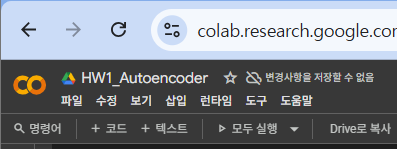

위와 같이 "변경사항을 저장할 수 없음"이라고 뜨는 것을 확인하실 수 있습니다.
코드 실행 및 과제 제출을 위해서는 상단의 파일 > Drive에 사본 저장을 눌러 본인 드라이브에 저장해 수정하시길 바랍니다~!!


# 오토인코더로 이미지의 특징을 추출하기

## 필요한 패키지 다운로드

In [45]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import numpy as np

## 하이퍼파라미터 사전 지정해주기
# 🚨선택 과제: 하이퍼 파라미터 조정하면서 결과 비교하기
# 🚨Hw1. DAE의 noise 강도(noise_factor), hidden layer 차원 정하기(hidden_dims)


In [46]:
# 하이퍼파라미터
EPOCH = 10
LR = 1e-3
BATCH_SIZE = 128


noise_factor = 0.3 # Denoising 강도
hidden_dims = [128, 64, 32, 3]  # SDAE 레이어 차원 축소 순서

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


## 데이터셋 다운로드 받아주기 원하는대로 변경 가능(아래는 예시)
### -> Fashion MNIST(의류 이미지 데이터):28*28
### -> KMNIST(일본어 이미지 데이터):28*28
### -> MNIST(숫자 데이터): 28*28

In [47]:

transform = transforms.ToTensor()
trainset = datasets.FashionMNIST(
                root='./data',
                train=True,
                download=True,
                transform=transform
                )
train_loader = torch.utils.data.DataLoader(
              trainset,
              batch_size=BATCH_SIZE,
              shuffle=True,
              num_workers=2
              )


## AutoEncoder 함수 정의하기
# 🚨Hw1. AE 인코더/디코더 구현

In [48]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()

          # TODO:nn.Linear(?, ?), nn.ReLU()
          # NIST 이미지는 28×28 픽셀 데이터로, 28*28(784)차원에서 시작합니다.
          # 아래에 지정하신 hidden dims의 index순서로 dimension reduction을 구현하세요.
          # 각 Linear layer 뒤에는 ReLU 함수를 반드시 사용합니다.



        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),

          # TODO:nn.Linear(?, ?), nn.ReLU()
          # 아래에 encoder의 반대 순으로 차원을 복원하세요.



            # 마지막 차원 복원
            nn.Linear(hidden_dims[0], 28*28),
            nn.Sigmoid()
        )
    def forward(self, x):

        encoded = self.encoder(x)#인코딩
        decoded = self.decoder(x)#디코딩
        return encoded, decoded


# 🚨HW 2. DAE 구현(노이즈 추가)


In [49]:
def build_dae(input_dim, hidden_dim):
    class DenoisingAutoencoder(nn.Module):
        def __init__(self):
            super().__init__()
            # encoder/decoder
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(True)
            )
            self.decoder = nn.Sequential(
                nn.Linear(hidden_dim, input_dim),
                nn.Sigmoid()
            )
        def forward(self, x):
            noisy = x + np.random.normal() * noise_factor# 노이즈 추가
            encoded = self.encoder(noisy)# 인코딩 결과로 노이즈 추가한 데이터 넣기)
            decoded = self.decoder(encoded)
            return encoded, decoded
    return DenoisingAutoencoder().to(DEVICE)


# 🚨Hw 3.SDAE 구현
- 코드가 복잡한 관계로 꼭 다 읽어보면서 구조를 파악해주세요


In [50]:
class StackedDAE(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()
        # encoder 모듈 리스트
        self.encoders = nn.ModuleList()
        prev_dim = input_dim
        for h in hidden_dims:
            self.encoders.append(nn.Sequential(nn.Linear(prev_dim, h), nn.ReLU(True)))#이전 AE의 레이어 가져오기)

            prev_dim = h
        # decoder 모듈 리스트
        self.decoders = nn.ModuleList()
        for d in reversed(hidden_dims):
            self.decoders.append(nn.Sequential(nn.Linear(prev_dim, d), nn.ReLU(True)))#이전 AE의 레이어 가져오기)

            prev_dim = d
        # 최종 복원층
        self.decoders.append(nn.Sequential(nn.Linear(prev_dim, input_dim), nn.Sigmoid()))


    def forward(self, x):
        encoded = x
        for enc in self.encoders:
            encoded = enc(encoded)
        decoded = encoded
        for dec in self.decoders:
            decoded = dec(decoded)
        return encoded, decoded

## Optimizer와 Loss 지정

In [51]:
sdae = StackedDAE(28*28, hidden_dims).to(DEVICE)
optimizer = torch.optim.Adam(sdae.parameters(), lr=LR)
criterion = nn.MSELoss()

  ## 원본 이미지를 첫번째 열에 시각화하는 함수 정의

In [52]:
# 원본 이미지를 시각화 하기
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor) / 255.

## training 함수 정의

In [53]:
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for x, _ in loader:
        x = x.view(-1, 28*28).to(DEVICE)
        target = x.clone()
        _, decoded = model(x)
        loss = criterion(decoded, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


## AutoEncoder 학습시키기 (약 2분 정도 소요)



In [54]:
for i, h in enumerate(hidden_dims):
    print(f"Pretraining Layer {i+1} (dim {h})...")
    dae = build_dae(28*28 if i==0 else hidden_dims[i-1], h)
    optimizer_layer = optim.Adam(dae.parameters(), lr=LR)
    for epoch in range(1, EPOCH+1):
        layer_loss = 0.0
        for x, _ in train_loader:
            x = x.view(-1, 28*28).to(DEVICE)
            # 이전 레이어 인코더 적용
            x_pre = x
            for j in range(i):
                x_pre, _ = sdae.encoders[j](x_pre), None
            # DAE 학습
            _, decoded = dae(x_pre)
            loss = criterion(decoded, x_pre)
            optimizer_layer.zero_grad()
            loss.backward()
            optimizer_layer.step()
            layer_loss += loss.item()
        print(f" Layer {i+1} Epoch {epoch}/{EPOCH} Loss: {layer_loss/len(train_loader):.4f}")
    # 가중치 복사
    sdae.encoders[i].load_state_dict(dae.encoder.state_dict())
    sdae.decoders[-(i+1)].load_state_dict(dae.decoder.state_dict())


Pretraining Layer 1 (dim 128)...
 Layer 1 Epoch 1/10 Loss: 0.0423
 Layer 1 Epoch 2/10 Loss: 0.0238
 Layer 1 Epoch 3/10 Loss: 0.0176
 Layer 1 Epoch 4/10 Loss: 0.0141
 Layer 1 Epoch 5/10 Loss: 0.0134
 Layer 1 Epoch 6/10 Loss: 0.0116
 Layer 1 Epoch 7/10 Loss: 0.0099
 Layer 1 Epoch 8/10 Loss: 0.0106
 Layer 1 Epoch 9/10 Loss: 0.0107
 Layer 1 Epoch 10/10 Loss: 0.0090
Pretraining Layer 2 (dim 64)...
 Layer 2 Epoch 1/10 Loss: 2.6850
 Layer 2 Epoch 2/10 Loss: 2.6170
 Layer 2 Epoch 3/10 Loss: 2.6044
 Layer 2 Epoch 4/10 Loss: 2.5979
 Layer 2 Epoch 5/10 Loss: 2.5930
 Layer 2 Epoch 6/10 Loss: 2.5890
 Layer 2 Epoch 7/10 Loss: 2.5854
 Layer 2 Epoch 8/10 Loss: 2.5818
 Layer 2 Epoch 9/10 Loss: 2.5782
 Layer 2 Epoch 10/10 Loss: 2.5761
Pretraining Layer 3 (dim 32)...
 Layer 3 Epoch 1/10 Loss: 72.6096
 Layer 3 Epoch 2/10 Loss: 72.3594
 Layer 3 Epoch 3/10 Loss: 72.3628
 Layer 3 Epoch 4/10 Loss: 72.3620
 Layer 3 Epoch 5/10 Loss: 72.3633
 Layer 3 Epoch 6/10 Loss: 72.3596
 Layer 3 Epoch 7/10 Loss: 72.3620
 La

SDAE Fine-tune Epoch [1/10] Loss: 0.0489
[Epoch 1]


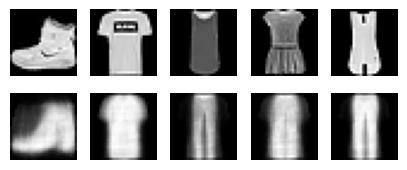

SDAE Fine-tune Epoch [2/10] Loss: 0.0336
[Epoch 2]


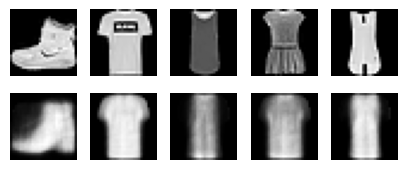

SDAE Fine-tune Epoch [3/10] Loss: 0.0319
[Epoch 3]


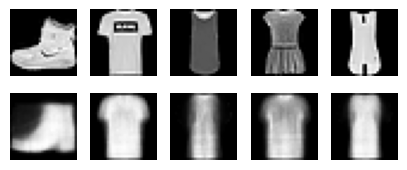

SDAE Fine-tune Epoch [4/10] Loss: 0.0308
[Epoch 4]


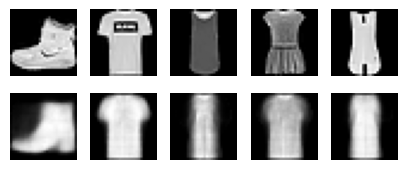

SDAE Fine-tune Epoch [5/10] Loss: 0.0300
[Epoch 5]


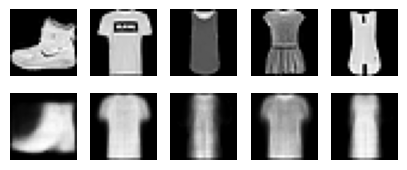

SDAE Fine-tune Epoch [6/10] Loss: 0.0295
[Epoch 6]


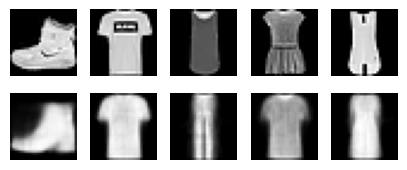

SDAE Fine-tune Epoch [7/10] Loss: 0.0291
[Epoch 7]


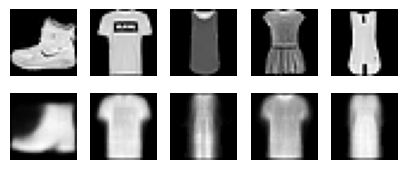

SDAE Fine-tune Epoch [8/10] Loss: 0.0287
[Epoch 8]


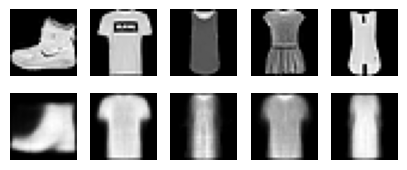

SDAE Fine-tune Epoch [9/10] Loss: 0.0284
[Epoch 9]


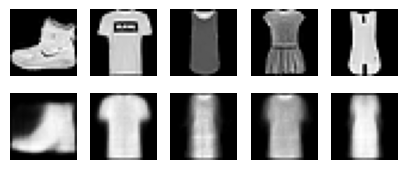

SDAE Fine-tune Epoch [10/10] Loss: 0.0282
[Epoch 10]


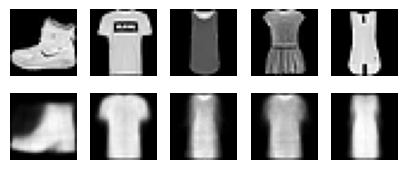

In [55]:
optimizer_sdae = optim.Adam(sdae.parameters(), lr=LR)
for epoch in range(1, EPOCH+1):
    total_loss = 0.0
    for x, _ in train_loader:
        x = x.view(-1, 28*28).to(DEVICE)
        _, decoded = sdae(x)
        loss = criterion(decoded, x)
        optimizer_sdae.zero_grad()
        loss.backward()
        optimizer_sdae.step()
        total_loss += loss.item()
    print(f"SDAE Fine-tune Epoch [{epoch}/{EPOCH}] Loss: {total_loss/len(train_loader):.4f}")

    # 시각화
    test_x = view_data.to(DEVICE)
    _, recon = sdae(test_x)
    recon = recon.cpu().detach().numpy()
    fig, ax = plt.subplots(2, 5, figsize=(5,2))
    print(f"[Epoch {epoch}]")
    for k in range(5):
        ax[0,k].imshow(view_data[k].reshape(28,28), cmap='gray')
        ax[0,k].axis('off')
        ax[1,k].imshow(recon[k].reshape(28,28), cmap='gray')
        ax[1,k].axis('off')
    plt.show()


# 잠재변수 들여다보기

In [56]:
# 잠재변수를 3D 플롯으로 시각화
view_data = trainset.data[:200].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = sdae(test_x)
encoded_data = encoded_data.to("cpu")

In [58]:
import pandas as pd
import plotly.express as px
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}
view_200 = trainset.data[:200].view(-1, 28*28).float()/255.
test_x = view_200.to(DEVICE)
encoded_data, _ = sdae(test_x)
encoded_data = encoded_data.cpu().data.numpy()
labels = trainset.targets[:200].numpy()

df = pd.DataFrame(encoded_data, columns=['x','y','z'])
df['label'] = [CLASSES[int(l)] for l in labels]

fig = px.scatter_3d(
    df,
    x='x', y='y', z='z',
    color='label',
    hover_name='label',
    opacity=0.7,
    width=800, height=600
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(
    scene=dict(
        xaxis_title='Latent Dim 1',
        yaxis_title='Latent Dim 2',
        zaxis_title='Latent Dim 3',
    ),
    legend_title_text='Class'
)
fig.show()

